In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import rgb2hex, Normalize
from matplotlib.cm import ScalarMappable
from scipy import stats

In [2]:
# load the dataSets
data = pd.read_csv('flights_train.csv', index_col=0)
testData = pd.read_csv('flights_test.csv',index_col=0)
airportData = pd.read_csv('airports.csv', low_memory=False)

C:\Users\siebr\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
# Evaluate the data
print(data.columns)
print(testData.columns)
print(airportData.columns)

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'TAXI_OUT', 'WHEELS_OFF',
       'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'SCHEDULED_ARRIVAL', 'ARRIVAL_DELAY'],
      dtype='object')
Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'TAXI_OUT', 'WHEELS_OFF',
       'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'SCHEDULED_ARRIVAL'],
      dtype='object')
Index(['IATA_CODE', 'AIRPORT', 'CITY', 'STATE', 'COUNTRY', 'LATITUDE',
       'LONGITUDE'],
      dtype='object')


In [4]:
originAirport = airportData[['LATITUDE', 'LONGITUDE', 'IATA_CODE']]
destenationAirport = airportData[['LATITUDE', 'LONGITUDE', 'IATA_CODE']]
originAirport.rename(columns={'LATITUDE':'ORIGIN_LATITUDE', 'LONGITUDE':'ORIGIN_LONGITUDE', 'IATA_CODE':'ORIGIN_AIRPORT'}, inplace=True)
destenationAirport.rename(columns={'LATITUDE':'DESTINATION_LATITUDE', 'LONGITUDE':'DESTINATION_LONGITUDE', 'IATA_CODE':'DESTINATION_AIRPORT'}, inplace=True)

C:\Users\siebr\anaconda3\lib\site-packages\pandas\core\frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [5]:
# Add coords to trainData
data = pd.merge(data, originAirport, on='ORIGIN_AIRPORT')
data = pd.merge(data, destenationAirport, on='DESTINATION_AIRPORT')
trainData = data
# remove null values
trainData = trainData.dropna()

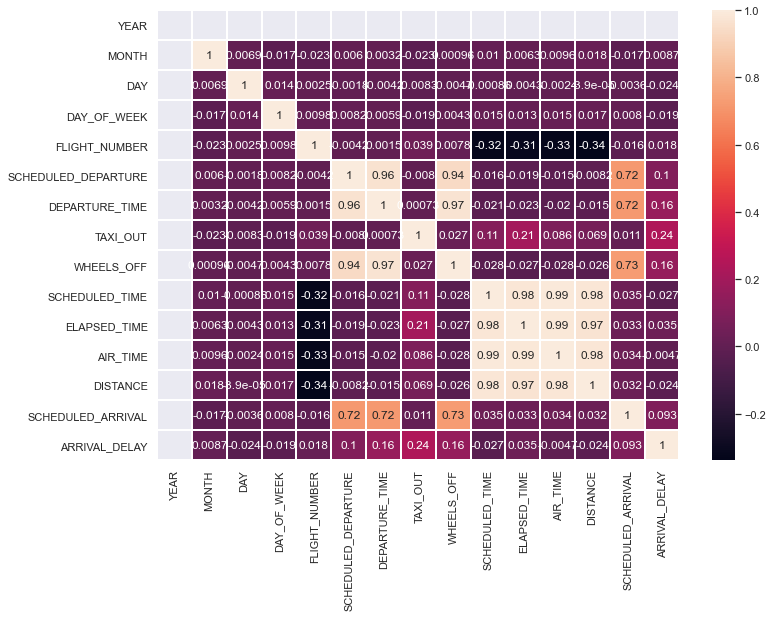

In [5]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns_plot = sns.heatmap(data.corr(),annot=True,lw=1)
figure = sns_plot.get_figure()    

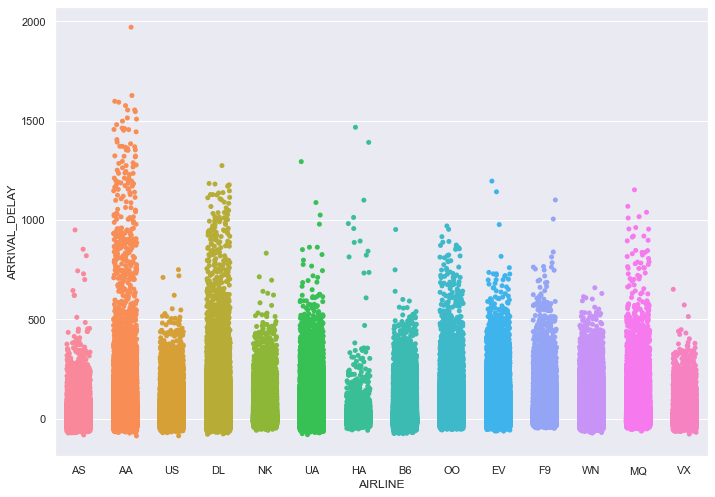

In [6]:
ax = sns.stripplot(x='AIRLINE', y='ARRIVAL_DELAY', data=trainData[['AIRLINE','ARRIVAL_DELAY']], jitter=0.25)

In [7]:
trainData['AIRLINE'].unique()

array(['AS', 'AA', 'US', 'DL', 'NK', 'UA', 'HA', 'B6', 'OO', 'EV', 'F9',
       'WN', 'MQ', 'VX'], dtype=object)

In [8]:
# check boxplots
airlinesDict = {}
for i in trainData['AIRLINE'].unique():
    selectValues = trainData['AIRLINE'] == i
    airlinesDict[i] = trainData[selectValues]['ARRIVAL_DELAY']

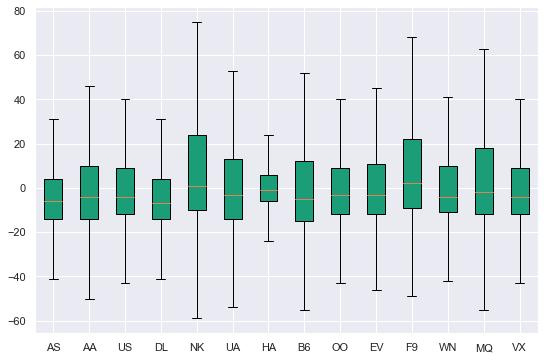

In [9]:
data_to_plot = list(airlinesDict.values())

# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

## Custom x-axis labels
ax.set_xticklabels(list(airlinesDict.keys()))

# Create the boxplot without outliers
bp = ax.boxplot(data_to_plot, showfliers=False, patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
#     box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

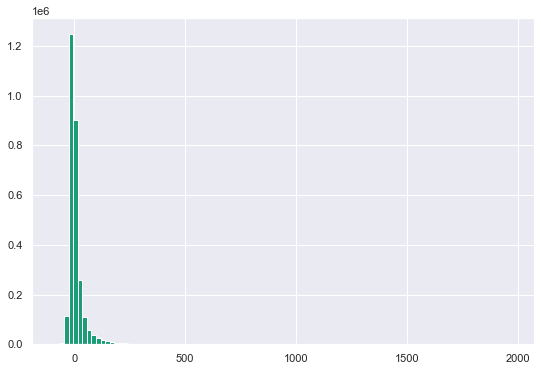

In [10]:
n_bins = 100

# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot without outliers
bp = ax.hist(trainData['ARRIVAL_DELAY'], bins=n_bins, color='#1b9e77')

In [42]:
# prepare data
# select collumns
mapData = trainData[['ARRIVAL_DELAY', 'ORIGIN_LATITUDE', 'ORIGIN_LONGITUDE', 'ORIGIN_AIRPORT']]
flightData = trainData[['ARRIVAL_DELAY', 'DESTINATION_LATITUDE', 'DESTINATION_LONGITUDE', 'DESTINATION_AIRPORT', 'ORIGIN_LATITUDE', 'ORIGIN_LONGITUDE', 'ORIGIN_AIRPORT']]

mapData['FLIGHTS'] = 1
flightData['FLIGHTS'] = 1

# select data
mapData = mapData.groupby(['ORIGIN_LATITUDE', 'ORIGIN_LONGITUDE', 'ORIGIN_AIRPORT'], as_index = False).agg({'ARRIVAL_DELAY':'mean','FLIGHTS':'sum'})
flightData = flightData.groupby(['DESTINATION_LATITUDE', 'DESTINATION_LONGITUDE', 'DESTINATION_AIRPORT', 'ORIGIN_LATITUDE', 'ORIGIN_LONGITUDE', 'ORIGIN_AIRPORT'], as_index = False).agg({'ARRIVAL_DELAY':'mean','FLIGHTS':'sum'})

# get only delay flights
lessThenZero = flightData['ARRIVAL_DELAY'] < 0
flightData = flightData[lessThenZero]

# remove outliers
flightData['z'] = 0
flightData['z'] = np.abs(stats.zscore(flightData['ARRIVAL_DELAY']))
for i in flightData.index:
    if flightData.at[i, 'z'] > 3:   
        flightData = flightData.drop(i)

# normalize amount of flights
flightData['FLIGHTS']=((flightData['FLIGHTS']-flightData['FLIGHTS'].min())/(flightData['FLIGHTS'].max()-flightData['FLIGHTS'].min()))*1
flightData['ARRIVAL_DELAY']=(1-((flightData['ARRIVAL_DELAY']-flightData['ARRIVAL_DELAY'].min())/(flightData['ARRIVAL_DELAY'].max()-flightData['ARRIVAL_DELAY'].min()))*1)

In [548]:
flightData

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DESTINATION_LATITUDE,DESTINATION_LONGITUDE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,205.0,194.0,169.0,1448,430,-22.0,61.17432,-149.99619,47.44898,-122.30931
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,45,...,204.0,194.0,173.0,1448,509,-14.0,61.17432,-149.99619,47.44898,-122.30931
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,45,...,210.0,200.0,171.0,1448,515,-24.0,61.17432,-149.99619,47.44898,-122.30931
3,2015,1,1,4,AS,134,N464AS,ANC,SEA,155,...,218.0,198.0,170.0,1448,633,-35.0,61.17432,-149.99619,47.44898,-122.30931
4,2015,1,1,4,AS,114,N303AS,ANC,SEA,220,...,200.0,199.0,176.0,1448,640,-12.0,61.17432,-149.99619,47.44898,-122.30931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818548,2015,6,28,7,OO,5315,N984CA,JMS,DVL,1318,...,40.0,35.0,19.0,83,1358,0.0,46.92972,-98.67820,48.11425,-98.90878
2818549,2015,6,28,7,OO,5465,N957SW,JMS,DVL,2350,...,40.0,38.0,21.0,83,30,-21.0,46.92972,-98.67820,48.11425,-98.90878
2818550,2015,6,29,1,OO,5315,N932EV,JMS,DVL,1318,...,40.0,35.0,18.0,83,1358,-13.0,46.92972,-98.67820,48.11425,-98.90878
2818551,2015,6,29,1,OO,5465,N918SW,JMS,DVL,2350,...,40.0,41.0,23.0,83,30,-3.0,46.92972,-98.67820,48.11425,-98.90878


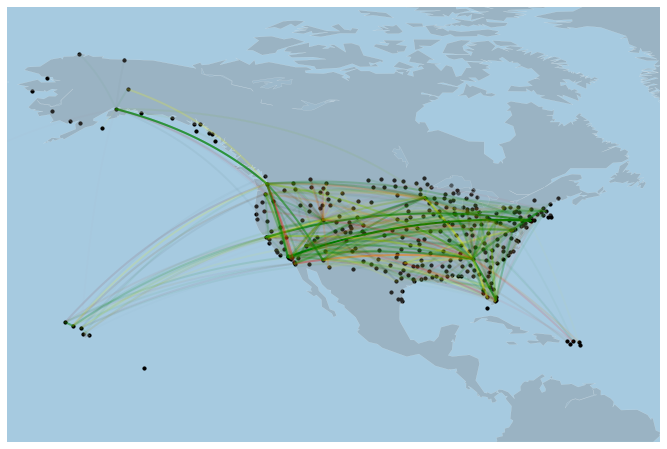

In [269]:
# # Set the dimension of the figure
# my_dpi=96
# plt.figure(figsize=(2600/my_dpi, 1800/my_dpi), dpi=my_dpi)

# # Make the background map
m=Basemap(llcrnrlon=-170, llcrnrlat=0,urcrnrlon=-50,urcrnrlat=80)

m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")

# # # prepare a color for each point depending on the continent.
# # data['labels_enc'] = pd.factorize(data['homecontinent'])[0]

# cmap = plt.cm.cool
# vmin = flightData['ARRIVAL_DELAY'].min(); vmax = flightData['ARRIVAL_DELAY'].max()
# norm = Normalize(vmin=-1, vmax=1)
# # color mapper to covert values to colors
# mapper = ScalarMappable(norm=norm, cmap=cmap)

# draw great circle route between NY and London
for i in flightData.index:
    if flightData['ARRIVAL_DELAY'][i] < 0.25:
        m.drawgreatcircle(flightData['ORIGIN_LONGITUDE'][i],flightData['ORIGIN_LATITUDE'][i],flightData['DESTINATION_LONGITUDE'][i],flightData['DESTINATION_LATITUDE'][i],linewidth=2,color='green', alpha=flightData['FLIGHTS'][i])
#         m.drawgreatcircle(flightData['ORIGIN_LONGITUDE'][i],flightData['ORIGIN_LATITUDE'][i],flightData['DESTINATION_LONGITUDE'][i],flightData['DESTINATION_LATITUDE'][i],linewidth=1,color=mapper.to_rgba(flightData['ARRIVAL_DELAY'][i]), alpha=1)
    elif flightData['ARRIVAL_DELAY'][i] < 0.5:
        m.drawgreatcircle(flightData['ORIGIN_LONGITUDE'][i],flightData['ORIGIN_LATITUDE'][i],flightData['DESTINATION_LONGITUDE'][i],flightData['DESTINATION_LATITUDE'][i],linewidth=2,color='yellow', alpha=flightData['FLIGHTS'][i])
    elif flightData['ARRIVAL_DELAY'][i] < 0.75:
        m.drawgreatcircle(flightData['ORIGIN_LONGITUDE'][i],flightData['ORIGIN_LATITUDE'][i],flightData['DESTINATION_LONGITUDE'][i],flightData['DESTINATION_LATITUDE'][i],linewidth=2,color='red', alpha=flightData['FLIGHTS'][i])
    else:
        m.drawgreatcircle(flightData['ORIGIN_LONGITUDE'][i],flightData['ORIGIN_LATITUDE'][i],flightData['DESTINATION_LONGITUDE'][i],flightData['DESTINATION_LATITUDE'][i],linewidth=2,color='black', alpha=flightData['FLIGHTS'][i])
        
# Add a point per position
# m.scatter(mapData['DESTINATION_LONGITUDE'], mapData['DESTINATION_LATITUDE'], s=mapData['FLIGHTS']/100, alpha=0.4, cmap="Set1", color="black")
m.scatter(mapData['ORIGIN_LONGITUDE'], mapData['ORIGIN_LATITUDE'], s=10, alpha=1, cmap="Set1", color="black")

# # # copyright and source data info
# plt.text( -170, -58,'Where people talk about #Surf\n\nData collected on twitter by @R_Graph_Gallery during 300 days\nPlot realized with Python and the Basemap library', ha='left', va='bottom', size=9, color='#555555' )

# plt.savefig('Bubble_map_neg_hil', bbox_inches='tight')
plt.show()


In [549]:
data

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DESTINATION_LATITUDE,DESTINATION_LONGITUDE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,205.0,194.0,169.0,1448,430,-22.0,61.17432,-149.99619,47.44898,-122.30931
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,45,...,204.0,194.0,173.0,1448,509,-14.0,61.17432,-149.99619,47.44898,-122.30931
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,45,...,210.0,200.0,171.0,1448,515,-24.0,61.17432,-149.99619,47.44898,-122.30931
3,2015,1,1,4,AS,134,N464AS,ANC,SEA,155,...,218.0,198.0,170.0,1448,633,-35.0,61.17432,-149.99619,47.44898,-122.30931
4,2015,1,1,4,AS,114,N303AS,ANC,SEA,220,...,200.0,199.0,176.0,1448,640,-12.0,61.17432,-149.99619,47.44898,-122.30931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818548,2015,6,28,7,OO,5315,N984CA,JMS,DVL,1318,...,40.0,35.0,19.0,83,1358,0.0,46.92972,-98.67820,48.11425,-98.90878
2818549,2015,6,28,7,OO,5465,N957SW,JMS,DVL,2350,...,40.0,38.0,21.0,83,30,-21.0,46.92972,-98.67820,48.11425,-98.90878
2818550,2015,6,29,1,OO,5315,N932EV,JMS,DVL,1318,...,40.0,35.0,18.0,83,1358,-13.0,46.92972,-98.67820,48.11425,-98.90878
2818551,2015,6,29,1,OO,5465,N918SW,JMS,DVL,2350,...,40.0,41.0,23.0,83,30,-3.0,46.92972,-98.67820,48.11425,-98.90878


In [566]:
timeData = data[['MONTH', 'DAY','DAY_OF_WEEK', 'ARRIVAL_DELAY', 'SCHEDULED_DEPARTURE']]
timeData['MONTH'] = timeData['MONTH'].apply('{:0>2}'.format)
timeData['DAY'] = timeData['DAY'].apply('{:0>2}'.format)
timeData['MONTH-DAY'] = timeData['MONTH'] + timeData['DAY']

timeData1 = timeData[['MONTH-DAY', 'ARRIVAL_DELAY']]
timeData1 = timeData1.groupby(['MONTH-DAY'], as_index = False)['ARRIVAL_DELAY'].mean()
timeData1

<ipython-input-566-faf209216688>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeData['MONTH'] = timeData['MONTH'].apply('{:0>2}'.format)
<ipython-input-566-faf209216688>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeData['DAY'] = timeData['DAY'].apply('{:0>2}'.format)
<ipython-input-566-faf209216688>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

,MONTH-DAY,ARRIVAL_DELAY
0,0101,5.352496
1,0102,9.838904
2,0103,25.461860
3,0104,31.975011
4,0105,18.811310
...,...,...
176,0626,12.033803
177,0627,12.207957
178,0628,7.081237
179,0629,2.693664


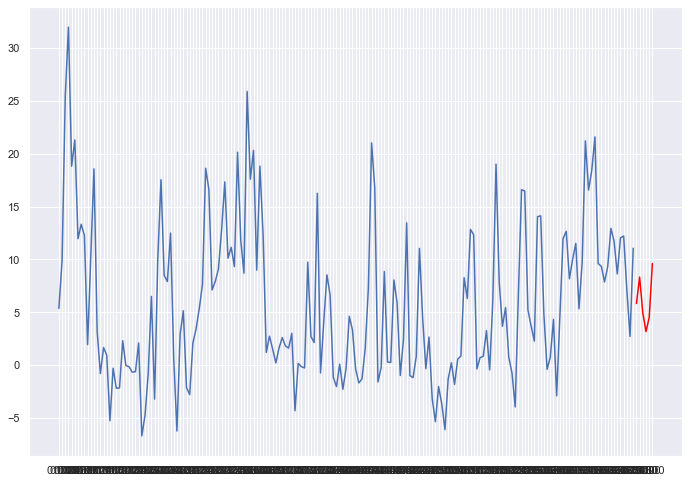

In [593]:
plt.plot(timeData1['MONTH-DAY'], timeData1['ARRIVAL_DELAY'])

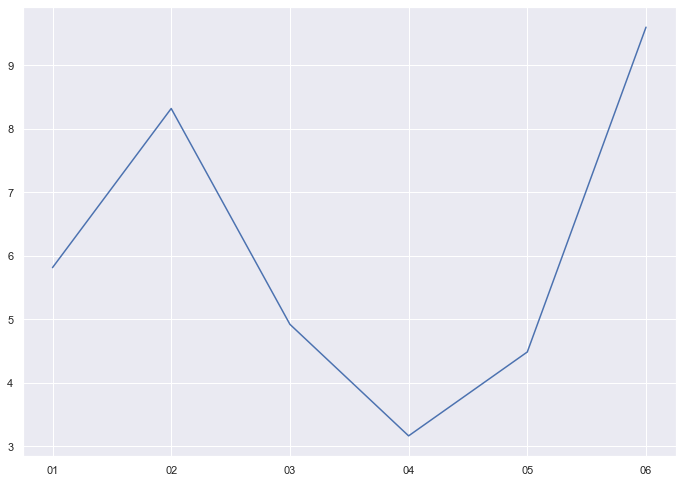

In [563]:
timeData2 = timeData[['MONTH', 'ARRIVAL_DELAY']]
timeData2 = timeData2.groupby(['MONTH'], as_index = False)['ARRIVAL_DELAY'].mean()
plt.plot(timeData2['MONTH'], timeData2['ARRIVAL_DELAY'])

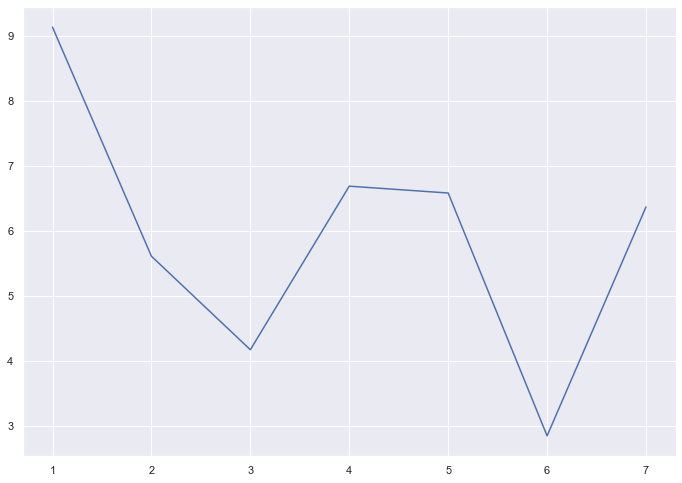

In [565]:
timeData3 = timeData[['DAY_OF_WEEK', 'ARRIVAL_DELAY']]
timeData3 = timeData3.groupby(['DAY_OF_WEEK'], as_index = False)['ARRIVAL_DELAY'].mean()
plt.plot(timeData3['DAY_OF_WEEK'], timeData3['ARRIVAL_DELAY'])

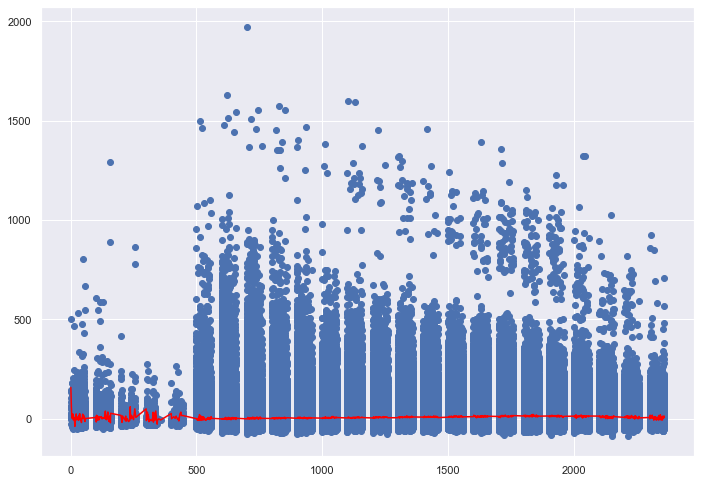

In [574]:
timeData4 = timeData[['SCHEDULED_DEPARTURE', 'ARRIVAL_DELAY']]
timeData4 = timeData4.groupby(['SCHEDULED_DEPARTURE'], as_index = False)['ARRIVAL_DELAY'].mean()

plt.scatter(timeData['SCHEDULED_DEPARTURE'], timeData['ARRIVAL_DELAY'])
plt.plot(timeData4['SCHEDULED_DEPARTURE'], timeData4['ARRIVAL_DELAY'], color='red')
plt.show()

# BASIC MODEL

### use airlines to predict

In [18]:
# airline = trainData['AIRLINE'] == 'OO'
# testModelData = trainData[airline]
testModelData = trainData

In [19]:
# Select 1 month
# month = testModelData['MONTH'] == 2
# testModelData = testModelData[month]

In [20]:
# Add departure hour
testModelData['SCHEDULED_DEPARTURE'] = testModelData['SCHEDULED_DEPARTURE'].apply('{:0>4}'.format)
testModelData['DEPARTURE_HOUR'] = testModelData['SCHEDULED_DEPARTURE'].str[:2]
# Add arrival hour
testModelData['SCHEDULED_ARRIVAL'] = testModelData['SCHEDULED_ARRIVAL'].apply('{:0>4}'.format)
testModelData['ARRIVAL_HOUR'] = testModelData['SCHEDULED_ARRIVAL'].str[:2]
testModelData

<ipython-input-20-84bc3eab7206>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testModelData['SCHEDULED_DEPARTURE'] = testModelData['SCHEDULED_DEPARTURE'].apply('{:0>4}'.format)
<ipython-input-20-84bc3eab7206>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testModelData['DEPARTURE_HOUR'] = testModelData['SCHEDULED_DEPARTURE'].str[:2]
<ipython-input-20-84bc3eab7206>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,AIR_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DESTINATION_LATITUDE,DESTINATION_LONGITUDE,DEPARTURE_HOUR,ARRIVAL_HOUR
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,0005,...,169.0,1448,0430,-22.0,61.17432,-149.99619,47.44898,-122.30931,00,04
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,0045,...,173.0,1448,0509,-14.0,61.17432,-149.99619,47.44898,-122.30931,00,05
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,0045,...,171.0,1448,0515,-24.0,61.17432,-149.99619,47.44898,-122.30931,00,05
3,2015,1,1,4,AS,134,N464AS,ANC,SEA,0155,...,170.0,1448,0633,-35.0,61.17432,-149.99619,47.44898,-122.30931,01,06
4,2015,1,1,4,AS,114,N303AS,ANC,SEA,0220,...,176.0,1448,0640,-12.0,61.17432,-149.99619,47.44898,-122.30931,02,06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818548,2015,6,28,7,OO,5315,N984CA,JMS,DVL,1318,...,19.0,83,1358,0.0,46.92972,-98.67820,48.11425,-98.90878,13,13
2818549,2015,6,28,7,OO,5465,N957SW,JMS,DVL,2350,...,21.0,83,0030,-21.0,46.92972,-98.67820,48.11425,-98.90878,23,00
2818550,2015,6,29,1,OO,5315,N932EV,JMS,DVL,1318,...,18.0,83,1358,-13.0,46.92972,-98.67820,48.11425,-98.90878,13,13
2818551,2015,6,29,1,OO,5465,N918SW,JMS,DVL,2350,...,23.0,83,0030,-3.0,46.92972,-98.67820,48.11425,-98.90878,23,00


In [21]:
testModelData.dtypes

YEAR                       int64
MONTH                      int64
DAY                        int64
DAY_OF_WEEK                int64
AIRLINE                   object
FLIGHT_NUMBER              int64
TAIL_NUMBER               object
ORIGIN_AIRPORT            object
DESTINATION_AIRPORT       object
SCHEDULED_DEPARTURE       object
DEPARTURE_TIME           float64
TAXI_OUT                 float64
WHEELS_OFF               float64
SCHEDULED_TIME           float64
ELAPSED_TIME             float64
AIR_TIME                 float64
DISTANCE                   int64
SCHEDULED_ARRIVAL         object
ARRIVAL_DELAY            float64
ORIGIN_LATITUDE          float64
ORIGIN_LONGITUDE         float64
DESTINATION_LATITUDE     float64
DESTINATION_LONGITUDE    float64
DEPARTURE_HOUR            object
ARRIVAL_HOUR              object
dtype: object

In [22]:
# create column that sets to 1 if delayed more then 0 otherwise to 0
# testModelData['DELAYED'] = np.where(testModelData['ARRIVAL_DELAY']>=10,1,0)

In [23]:
testModelData.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,AIR_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DESTINATION_LATITUDE,DESTINATION_LONGITUDE,DEPARTURE_HOUR,ARRIVAL_HOUR
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,0005,...,169.0,1448,0430,-22.0,61.17432,-149.99619,47.44898,-122.30931,00,04
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,0045,...,173.0,1448,0509,-14.0,61.17432,-149.99619,47.44898,-122.30931,00,05
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,0045,...,171.0,1448,0515,-24.0,61.17432,-149.99619,47.44898,-122.30931,00,05
3,2015,1,1,4,AS,134,N464AS,ANC,SEA,0155,...,170.0,1448,0633,-35.0,61.17432,-149.99619,47.44898,-122.30931,01,06
4,2015,1,1,4,AS,114,N303AS,ANC,SEA,0220,...,176.0,1448,0640,-12.0,61.17432,-149.99619,47.44898,-122.30931,02,06


In [24]:
# DISTANCEGROUP
dummy_fields = ['ARRIVAL_HOUR', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'AIRLINE']
for each in dummy_fields:
    dummies = pd.get_dummies(testModelData[each], prefix=each, drop_first=False)
    testModelData = pd.concat([testModelData, dummies], axis=1)
testModelData.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,AIRLINE_EV,AIRLINE_F9,AIRLINE_HA,AIRLINE_MQ,AIRLINE_NK,AIRLINE_OO,AIRLINE_UA,AIRLINE_US,AIRLINE_VX,AIRLINE_WN
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,0005,...,0,0,0,0,0,0,0,0,0,0
1,2015,1,1,4,AS,108,N309AS,ANC,SEA,0045,...,0,0,0,0,0,0,0,0,0,0
2,2015,1,1,4,DL,1560,N3743H,ANC,SEA,0045,...,0,0,0,0,0,0,0,0,0,0
3,2015,1,1,4,AS,134,N464AS,ANC,SEA,0155,...,0,0,0,0,0,0,0,0,0,0
4,2015,1,1,4,AS,114,N303AS,ANC,SEA,0220,...,0,0,0,0,0,0,0,0,0,0


In [25]:
testModelData = testModelData.drop(dummy_fields, axis=1)

In [26]:
testModelData

,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,TAIL_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,...,AIRLINE_EV,AIRLINE_F9,AIRLINE_HA,AIRLINE_MQ,AIRLINE_NK,AIRLINE_OO,AIRLINE_UA,AIRLINE_US,AIRLINE_VX,AIRLINE_WN
0,2015,1,1,4,98,N407AS,0005,2354.0,21.0,15.0,...,0,0,0,0,0,0,0,0,0,0
1,2015,1,1,4,108,N309AS,0045,41.0,17.0,58.0,...,0,0,0,0,0,0,0,0,0,0
2,2015,1,1,4,1560,N3743H,0045,31.0,25.0,56.0,...,0,0,0,0,0,0,0,0,0,0
3,2015,1,1,4,134,N464AS,0155,140.0,17.0,157.0,...,0,0,0,0,0,0,0,0,0,0
4,2015,1,1,4,114,N303AS,0220,209.0,15.0,224.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818548,2015,6,28,7,5315,N984CA,1318,1323.0,10.0,1333.0,...,0,0,0,0,0,1,0,0,0,0
2818549,2015,6,28,7,5465,N957SW,2350,2331.0,12.0,2343.0,...,0,0,0,0,0,1,0,0,0,0
2818550,2015,6,29,1,5315,N932EV,1318,1310.0,10.0,1320.0,...,0,0,0,0,0,1,0,0,0,0
2818551,2015,6,29,1,5465,N918SW,2350,2346.0,12.0,2358.0,...,0,0,0,0,0,1,0,0,0,0


In [27]:
trainData2 = testModelData
trainData3 = trainData2.drop(columns=['YEAR', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'DEPARTURE_TIME' , 'TAXI_OUT', 'AIR_TIME', 'DISTANCE'])

In [30]:
# ReduceDataSet
trainData3=trainData3.sample(frac=0.2,random_state=200)

X = trainData3.drop(columns='ARRIVAL_DELAY')
Y = trainData3['ARRIVAL_DELAY']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)



(450202, 690) (112551, 690) (450202,) (112551,)


In [31]:
# X_test = testData[['DEPARTURE_DELAY']]

In [32]:
#This creates a LinearRegression object
lm = LinearRegression()
lm.fit(X_train, Y_train)
#print the intercept and number of coefficients.
print('Estimated intercept coefficient:', lm.intercept_)
print('Number of coefficients:', len(lm.coef_))

Estimated intercept coefficient: -2380744812.5803804
Number of coefficients: 690


In [33]:
# #Construct a data frame that contains features and estimated coefficients.
# pd.DataFrame(list(zip(X.columns, lm.coef_)), columns = ['features', 'estimatedCoefficients'])

In [34]:
# R^2 scores
print('Train:', lm.score(X_train, Y_train))
print('Test:', lm.score(X_test, Y_test))

Train: 0.1711404429632858
Test: -33126991.301712297


In [538]:
predictions = lm.predict(X_test)

In [539]:
mae = mean_absolute_error(Y_test, predictions)
print('MAE: %.3f' % mae)
print('MAE: %.3f random ' % abs(Y_test - Y_test.mean()).mean())

MAE: 18.531
MAE: 23.961 random 


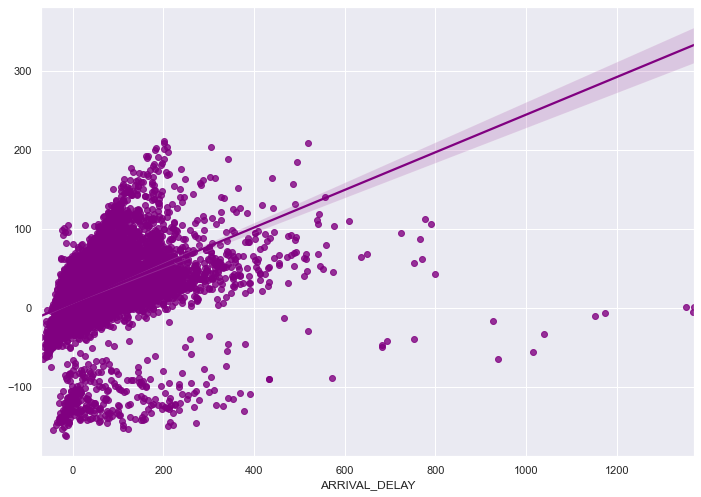

In [540]:
sns_plot2 = sns.regplot(Y_test,predictions, color='purple')
figure2 = sns_plot2.get_figure()    
# figure2.savefig('correlation_random_forrest.png')

In [35]:
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(X_train, Y_train)
# R^2 scores
print('Train:', regressor.score(X_train, Y_train))
print('Test:', regressor.score(X_test, Y_test))

Train: 0.9897503178724589
Test: 0.8939519405441364


In [36]:
predictions2 = regressor.predict(X_test)

In [37]:
mae = mean_absolute_error(Y_test, predictions2)
print('MAE: %.3f' % mae)
print('MAE: %.3f random ' % abs(Y_test - Y_test.mean()).mean())

MAE: 6.016
MAE: 22.457 random 


# FINAL PREDICTION

In [40]:
testData

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,SCHEDULED_ARRIVAL
id,,,,,,,,,,,,,,,,,,
0,2015,7,1,3,NK,298,N624NK,LAS,IAH,3,41.0,11.0,52.0,177.0,179.0,159.0,1222,500
1,2015,7,1,3,AA,1965,N507AY,SFO,CLT,5,2400.0,21.0,21.0,303.0,306.0,270.0,2296,808
2,2015,7,1,3,DL,2020,N3759,LAX,MEM,5,2400.0,36.0,36.0,223.0,244.0,206.0,1619,548
3,2015,7,1,3,NK,612,N629NK,LAS,MSP,5,53.0,14.0,107.0,178.0,179.0,157.0,1299,503
4,2015,7,1,3,UA,1044,N39418,ANC,ORD,8,17.0,20.0,37.0,364.0,358.0,327.0,2846,912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514379,2015,7,31,5,DL,919,N835DN,PDX,DTW,2359,2356.0,12.0,8.0,248.0,228.0,209.0,1953,707
514380,2015,7,31,5,DL,1846,N372DA,PDX,ATL,2359,12.0,10.0,22.0,274.0,251.0,234.0,2172,733
514381,2015,7,31,5,F9,682,N922FR,DEN,MCO,2359,2355.0,14.0,9.0,213.0,196.0,172.0,1546,532


In [41]:
# Add coords to trainData
testData = pd.merge(testData, originAirport, on='ORIGIN_AIRPORT')
testData = pd.merge(testData, destenationAirport, on='DESTINATION_AIRPORT')
# remove null values
testData = testData.dropna()

In [42]:
# Add departure hour
testData['SCHEDULED_DEPARTURE'] = testData['SCHEDULED_DEPARTURE'].apply('{:0>4}'.format)
testData['DEPARTURE_HOUR'] = testData['SCHEDULED_DEPARTURE'].str[:2]
# Add arrival hour
testData['SCHEDULED_ARRIVAL'] = testData['SCHEDULED_ARRIVAL'].apply('{:0>4}'.format)
testData['ARRIVAL_HOUR'] = testData['SCHEDULED_ARRIVAL'].str[:2]

In [43]:
# DISTANCEGROUP
dummy_fields = ['ARRIVAL_HOUR', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'AIRLINE']
for each in dummy_fields:
    dummies = pd.get_dummies(testData[each], prefix=each, drop_first=False)
    testData = pd.concat([testData, dummies], axis=1)
testData.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,AIRLINE_DL,AIRLINE_EV,AIRLINE_F9,AIRLINE_HA,AIRLINE_MQ,AIRLINE_NK,AIRLINE_OO,AIRLINE_UA,AIRLINE_VX,AIRLINE_WN
0,2015,7,1,3,NK,298,N624NK,LAS,IAH,0003,...,0,0,0,0,0,1,0,0,0,0
1,2015,7,1,3,UA,1981,N76508,LAS,IAH,0032,...,0,0,0,0,0,0,0,1,0,0
2,2015,7,1,3,UA,1194,N14242,LAS,IAH,0640,...,0,0,0,0,0,0,0,1,0,0
3,2015,7,1,3,UA,566,N849UA,LAS,IAH,0841,...,0,0,0,0,0,0,0,1,0,0
4,2015,7,1,3,UA,1596,N33292,LAS,IAH,0939,...,0,0,0,0,0,0,0,1,0,0


In [44]:
testData = testData.drop(dummy_fields, axis=1)

In [45]:
testData = testData.drop(columns=['YEAR', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'DEPARTURE_TIME' , 'TAXI_OUT', 'AIR_TIME', 'DISTANCE'])

In [62]:
missingCols = X_test.columns.difference(testData.columns)

In [65]:
for col in missingCols:
    testData[col] = 0

In [66]:
FinalPrediction = regressor.predict(testData)

In [71]:
finalDataset = pd.DataFrame(data=FinalPrediction, columns=['ARRIVAL_DELAY'])

In [77]:
# save file
finalDataset.to_csv('prediction.csv', index_label='id')

In [78]:
finalDataset

,ARRIVAL_DELAY
0,8.2
1,42.7
2,-12.2
3,-9.9
4,4.1
...,...
513335,10.0
513336,-7.3
513337,-10.9
513338,-0.5


In [ ]:
# remove outliers
testModelData['z'] = 0
testModelData['z'] = np.abs(stats.zscore(testModelData['ARRIVAL_DELAY']))
for i in testModelData.index:
    if testModelData.at[i, 'z'] > 3:   
        testModelData = testModelData.drop(i)
testModelData